# A simple 5-parameter $w_a$ blinded fit

### ROOT and blinding functions import
See https://cdcvs.fnal.gov/redmine/projects/gm2analyses/wiki/Library_installation for a local installation of Blinding libraries for Python3

In [1]:
import sys, math 
sys.path.append("/usr/local/Cellar/root/6.16.00_3/lib/root") # add brew ROOT (Mac) the system path ($JUPYTER_PATH)
sys.path.append("Blinding/") # folder with Blinders and libBlinders.so
import ROOT as r
from ROOT import TFile, TStyle, TCanvas, gStyle, TF1, gROOT, TMath, TLegend
r.gROOT.Macro("~/rootlogon.C") #if you have a rootlogon.C / g2PlotStyle https://cdcvs.fnal.gov/redmine/projects/g-2/wiki/PlotStyleGuide
gStyle.SetOptStat(0) # we only want the event number in range (i.e. integral)
gStyle.SetOptFit(0) # use legend to put fit details 
from BlindersPy3 import Blinders
from BlindersPy3 import FitType

Welcome to JupyROOT 6.16/00


### Set blinding here

In [2]:
# unblinded instance (for testing-only!)
# getBlinded = Blinders(FitType.Omega_a) # this will scream "You are not blind!"
# blinded=False

# blinded instance with your favorite phrase
getBlinded = Blinders(FitType.Omega_a, "EDM all day") # will tell you that you are blinded
blinded=True 

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


### Define blinded fit function $N(t)=Ne^{-t/\tau}[1+A\cos(\omega_at+\phi)]$,
where  
[0] $N$ is the overall normalisation  
[1] $\tau$ is the boosted muon lifetime $\tau = \gamma \cdot \tau_0 = 29.3\cdot2.2=66.44 \, \mu$s  
[2] $A$ is the asymmetry  
[3] $\omega_a$ is the anomalous precision frequency  
[4] $\phi$ is the initial phase  

In [3]:
def blinded_wiggle_function(x, pars):
    norm  = pars[0]
    life  = pars[1]
    asym  = pars[2]
    R     = pars[3]
    phi   = pars[4]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R)
    
    return norm * math.exp(-time/life) * (1 + asym*math.cos(omega*time + phi))

### Open ROOT file with a wiggle histogram and set some cuts (time)

In [4]:
file= "/Users/gleb/software/EDMTracking/DATA/9d_6runs.root"
stations=("S12", "S18")
plot =  "/TrackFit/Time_1800MeV" # plot path in the ROOT file 
xmin=30 # us 
xmax=150 # us 
t_file = TFile.Open(file) 
plots=[]
for station in stations:
    print(station+plot)
    plots.append(t_file.Get(station+plot))

S12/TrackFit/Time_1800MeV
S18/TrackFit/Time_1800MeV


In [5]:
print(plots)

[<ROOT.TH1F object ("Time_1800MeV") at 0x7fae20737280>, <ROOT.TH1F object ("Time_1800MeV") at 0x7fae2078b1d0>]


## Display the wiggle histogram

208220 tracks in range 30 to 150 [us]
180676 tracks in range 30 to 150 [us]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


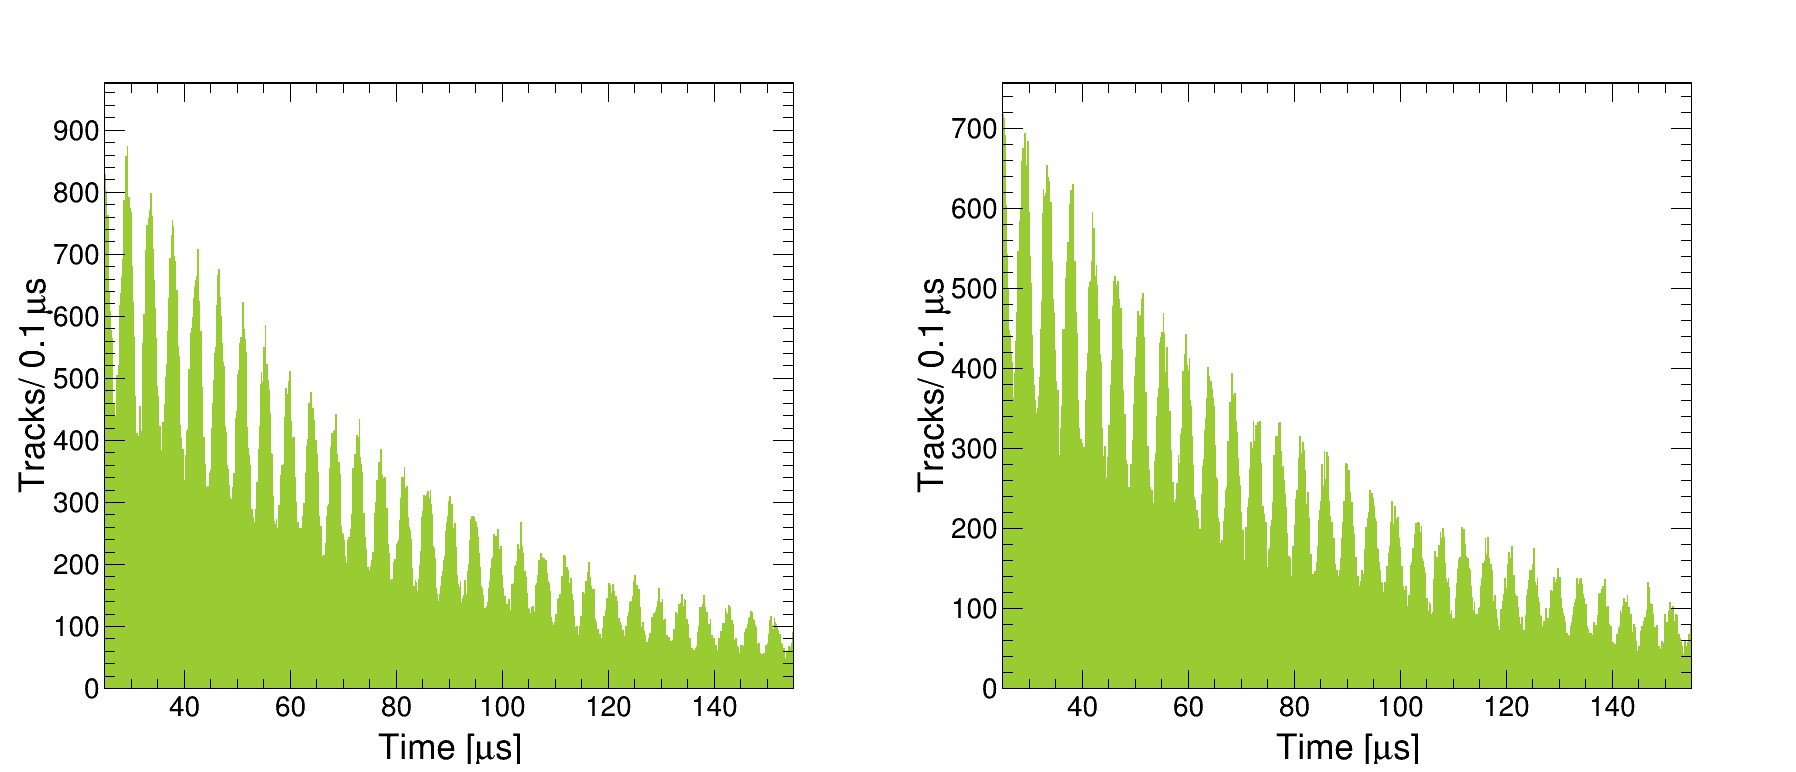

In [7]:
c1 = TCanvas("c1", "", 1800, 800) 
c1.Divide(2)
entries=[]
for i, plot in enumerate(plots):
    c1.cd(i+1)
    plot.Draw()
    Xaxis = plot.GetXaxis()
    Yaxis = plot.GetYaxis()
    Xaxis.SetRangeUser(xmin-5, xmax+5) # apply the time cut (display purpose only +/-5 us to see start/end of the fit)
    # Find the number of events in range
    bmin = Xaxis.FindBin(xmin)
    bmax = Xaxis.FindBin(xmax)
    entries.append(plot.Integral(bmin,bmax))
    print(int(entries[i]), "tracks in range",xmin,"to",xmax,"[us]")
    binW=plot.GetBinWidth(1) 
    Xaxis.SetTitle("Time [#mus]")
    plot.GetYaxis().SetTitle("Tracks/ %.1f #mus" % binW)
    Xaxis.CenterTitle()
    Yaxis.CenterTitle()
c1.Draw();

## Now we can set some initial guess on the parameters and do a blinded fit

In [8]:
func = TF1("func", blinded_wiggle_function, xmin, xmax, 5) # use our defined function in range with 5 parameters
func.SetParNames('N','#tau','A','R','#phi') # name the parameters 
func.SetParameters(20000, 64.4 , 0.4 ,0.0, 0.0) # initial guess 
func.SetLineColor(2) # red 
func.SetNpx(10000) # prevent under-sampling (display only)
if(blinded==False):
    print("You are not blinded!")

## Now we can set some initial guess on the parameters and do a blinded fit

 FCN=829.793 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS         382 TOTAL
                     EDM=9.24662e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            1.03847e+03   5.67709e+00  -8.77081e-03  -2.40995e-06
   2  #tau         5.74253e+01   2.33912e-01   1.39574e-04  -2.79593e-05
   3  A            3.46742e-01   2.95105e-03  -1.18194e-05   9.22708e-04
   4  R            6.94861e-01   1.93969e+02  -8.68679e-03   1.56334e-07
   5  #phi         2.04858e+00   2.15336e-02   2.15336e-02   2.90226e-03
 FCN=808.997 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS         384 TOTAL
                     EDM=2.18468e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            8.32961e+02   

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Info in <TCanvas::Print>: png file wiggle_blinded_both.png has been created


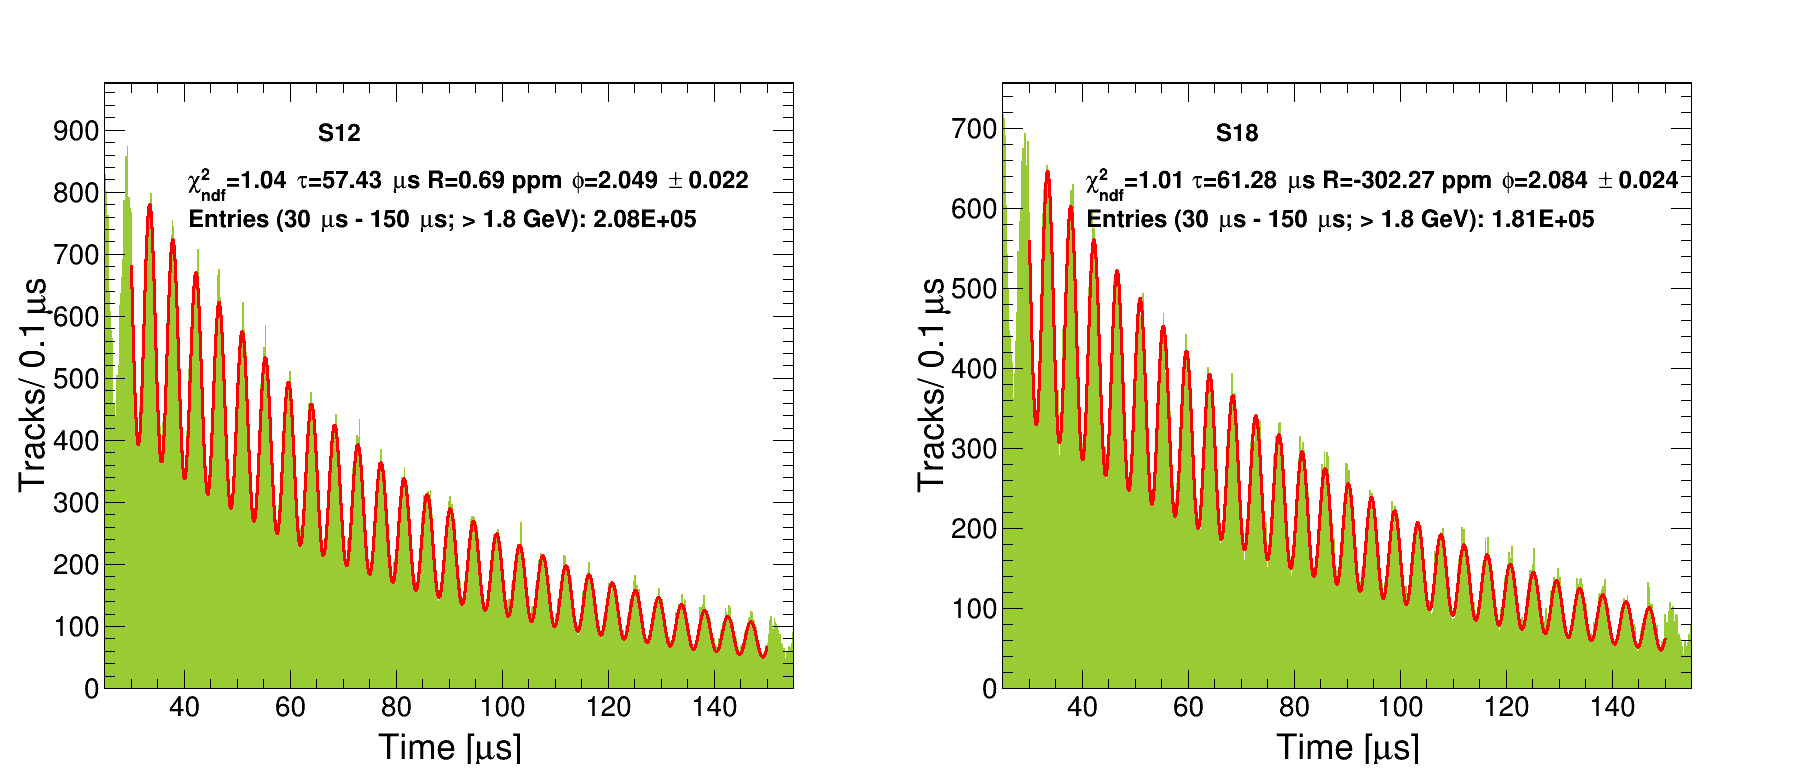

In [19]:
c2 = TCanvas("c2", "", 1800, 800) 
c2.Divide(2)
legendArray=[]
for i, plot in enumerate(plots):
    c2.cd(i+1)
    plot.Fit('func','REM') # fit in range (R), TMinut fit (M), Minos errors (E)

    # Get the fit parameters
    chi2=func.GetChisquare()
    ndf=func.GetNDF()
    ch2ndf=chi2/ndf
    LT = func.GetParameter(1)
    LT_error = func.GetParError(1)
    R= func.GetParameter(3)
    phi = func.GetParameter(4)
    phi_error = func.GetParError(4)

    # Set and draw legend
    legend =  TLegend(0.03,0.70,0.70,0.88)
    legendArray.append(legend) # stroe all to keep in scope 
    legend.SetHeader(stations[i], "C")
    legenValue1 = "#chi^{2}_{ndf}=%.2f #tau=%.2f #mus R=%0.2f ppm #phi=%.3f #pm %.3f" % (ch2ndf, LT, R, phi, phi_error)
    legenValue2 = "Entries (30 #mus - 150 #mus; > 1.8 GeV): %.2E" % entries[i]
    legend.AddEntry(func, "#splitline{"+str(legenValue1)+"}{"+str(legenValue2)+"}", "")
    gStyle.SetLegendBorderSize(0)
    gStyle.SetLegendTextSize(0.034)
    legend.SetFillStyle(0)
    legend.Draw()

c2.Draw()
c2.SaveAs("wiggle_blinded_both.png")

In [13]:
r.enableJSVis()
# r.disableJSVis()

In [14]:
c.Draw()